# Craft Beer Predictions

I have performed some exploratory analysis on this data in a previous notebook. I will use notebook to perform some predictions on the Style  

In [1]:
import numpy as np
import pandas as pd
#from dateutil.parser import parse
#from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb

## Load the cleaned data

In [4]:
recipe = pd.read_csv('Data/cleaned_recipe.csv',encoding='latin1')
recipe.head()

,BeerID,Name,URL,Size(L),ABV,IBU,Color,BoilSize,BoilTime,Efficiency,...,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,Top5_Style,OG_sg,FG_sg,BoilGravity_sg
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,21.77,5.48,17.65,4.83,28.39,75,70.0,...,0,1,1,0,0,0,Other,1.055,1.013,1.038
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,20.82,8.16,60.65,15.64,24.61,60,70.0,...,0,1,1,0,0,0,Specialty,1.083,1.021,1.070
2,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,50.00,6.48,17.84,4.57,60.00,90,72.0,...,0,1,1,0,0,0,Belgian,1.060,1.010,1.050
3,6,Sierra Nevada Pale Ale Clone,/homebrew/recipe/view/28546/sierra-nevada-pale...,24.61,5.58,40.12,8.00,29.34,70,79.0,...,0,1,1,0,0,0,Pale Ale,1.055,1.013,1.047
4,8,Spotted Clown (New Glarus Spotted Cow clone),/homebrew/recipe/view/672/spotted-clown-new-gl...,20.82,5.36,19.97,5.94,28.39,75,70.0,...,0,1,1,0,0,0,Other,1.054,1.014,1.040


## Set the features to be included.
All features will be inlcuded as a first pass to the model.

I may decide to try to optimise the feature selection and the model fitting.

In [5]:
recipe.columns

Index(['BeerID', 'Name', 'URL', 'Size(L)', 'ABV', 'IBU', 'Color', 'BoilSize',
       'BoilTime', 'Efficiency', 'Parent_Style', 'SugarScale_Plato',
       'SugarScale_Specific Gravity', 'BrewMethod_All Grain',
       'BrewMethod_BIAB', 'BrewMethod_Partial Mash', 'BrewMethod_extract',
       'Top5_Style', 'OG_sg', 'FG_sg', 'BoilGravity_sg'],
      dtype='object')

In [6]:
features = ['Size(L)', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'Efficiency', 
            'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash', 'BrewMethod_extract', 
            'OG_sg', 'FG_sg', 'BoilGravity_sg']



## Create the modelling steps

In [7]:
# Create dummy variable for the taget value: Belgian

def set_target(data, target_style = 'Pale Ale'):
    target = target_style
    data[target] = 0
    data[target][data['Parent_Style'] == target_style] = 1

    print ('Number of',target,'recipes:',len(data[data['Parent_Style'] == target_style]))
    
    return data


In [8]:
def split_data(data,features,target):
    
    X = data[features]
    y = data[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test


In [9]:
def train_model(X_train, X_test, y_train, y_test):

    model = LogisticRegressionCV();
    model.fit(X_train, y_train);

    scores = cross_val_score(model, X_test, y_test, cv=5);
        
    print ('Testing score:', scores.mean())
    
    return model

In [10]:
# Generate the prediction values for each of the test observations using predict_proba()
# function rather than just predict
def plot_roc(model, X_test, y_test,title=''):
    preds = model.predict_proba(X_test)[:,1];

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds);

    # Store the Area Under the Curve (AUC) so we can annotate our graph with these metric
    roc_auc = metrics.auc(fpr, tpr);

    # Plot the ROC Curve
    plt.figure(figsize=(12,10))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for '+title)
    plt.legend(loc = "lower right")
    plt.show()
    


In [11]:
def workflow(data, features, target):
    data = set_target(data, target_style = target)
    X_train, X_test, y_train, y_test = split_data(data, features, target)
    model = train_model(X_train, X_test, y_train, y_test)
    plot_roc(model, X_test, y_test, target)
    
    return model

# Predict the desired target style

Number of IPA recipes: 16414
Testing score: 0.8475606632469684


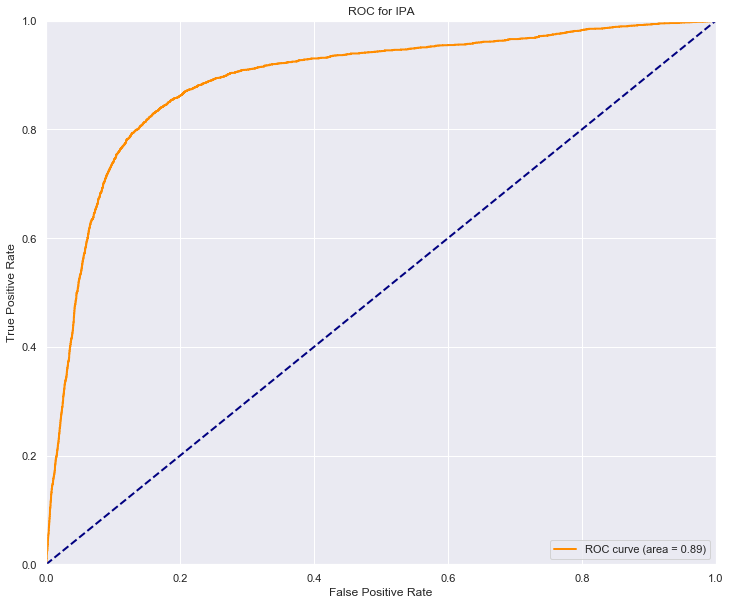

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [12]:

target = 'IPA'
workflow(recipe, features, target)

Number of Belgian recipes: 9847
Testing score: 0.8561399684735307


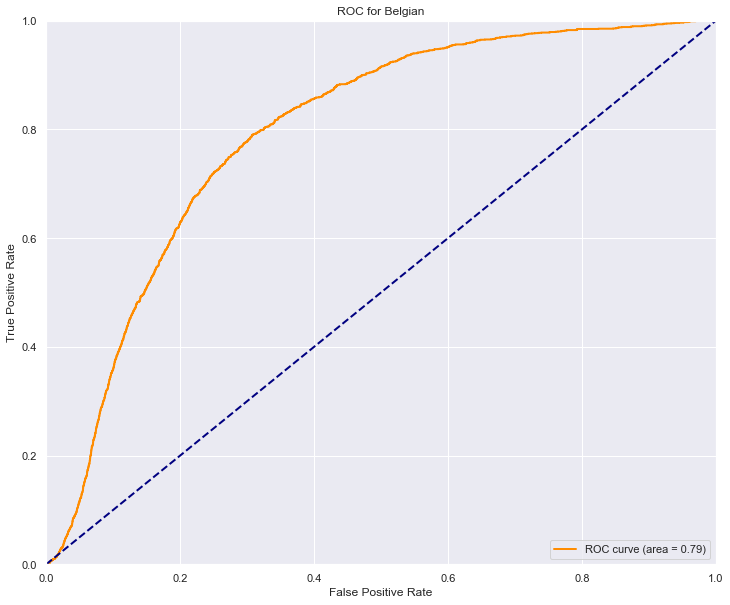

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [13]:
target = 'Belgian'
workflow(recipe, features, target)

Number of Pale Ale recipes: 7954
Testing score: 0.887124247322367


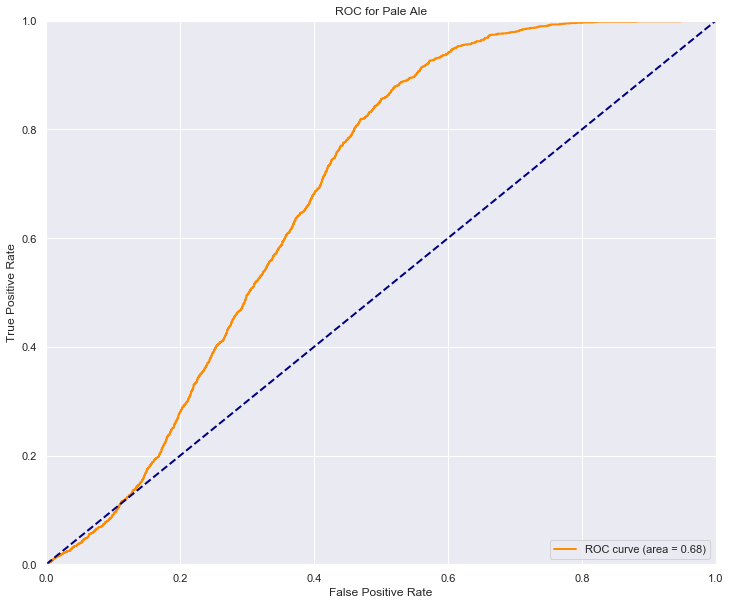

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [14]:

target = 'Pale Ale'
workflow(recipe, features, target)

Number of Other recipes: 6961
Testing score: 0.9012337711295746


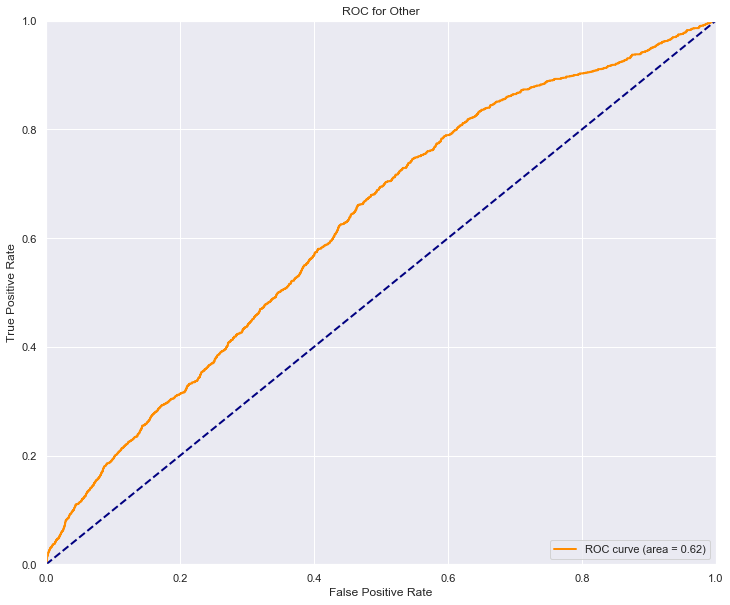

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [15]:

target = 'Other'
workflow(recipe, features, target)

Number of Stout recipes: 5697
Testing score: 0.9474612644276338


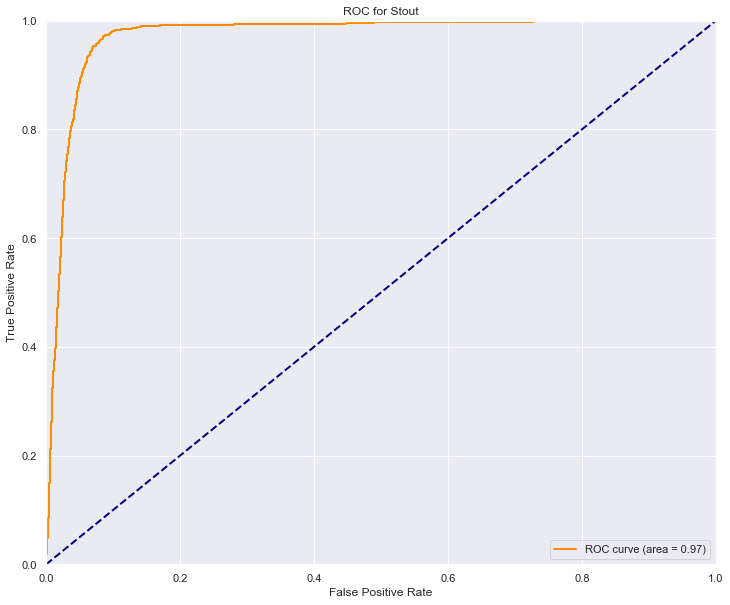

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [16]:
target = 'Stout'
workflow(recipe, features, target)

Number of Lager recipes: 5240
Testing score: 0.9254822581661658


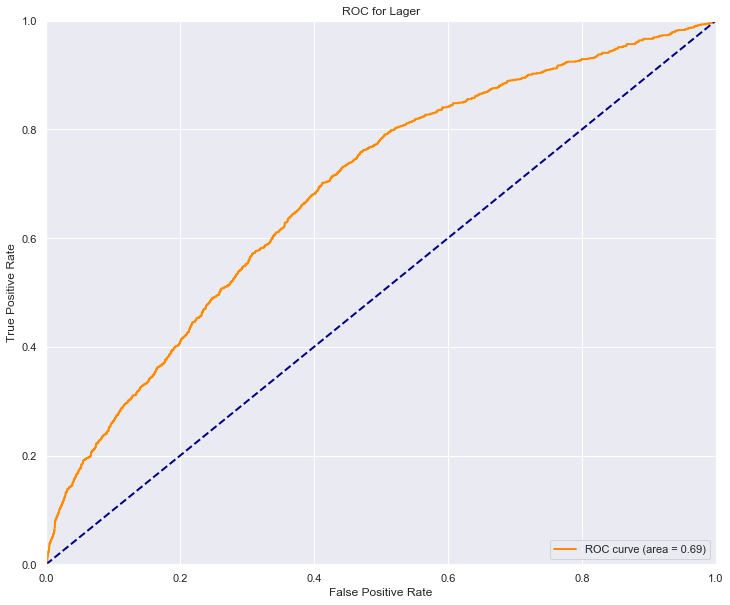

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [17]:
target = 'Lager'
workflow(recipe, features, target)

Number of German recipes: 3828
Testing score: 0.9455473988186078


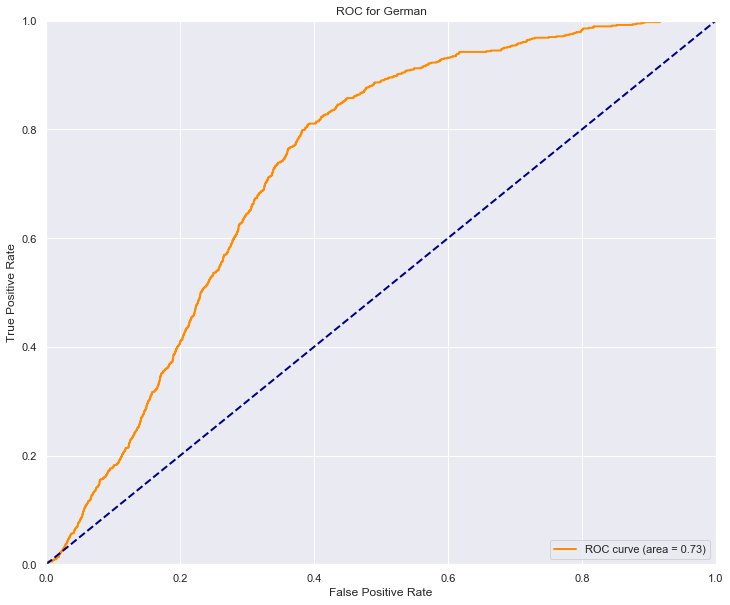

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [18]:
target = 'German'
workflow(recipe, features, target)

Number of Specialty recipes: 2488
Testing score: 0.9646909055721471


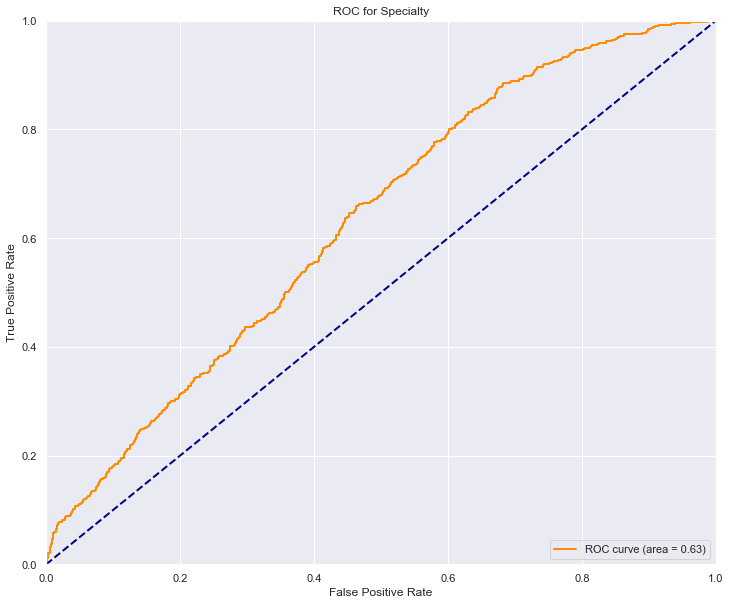

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [19]:
target = 'Specialty'
workflow(recipe, features, target)

Number of Brown recipes: 2369
Testing score: 0.9663216353538934


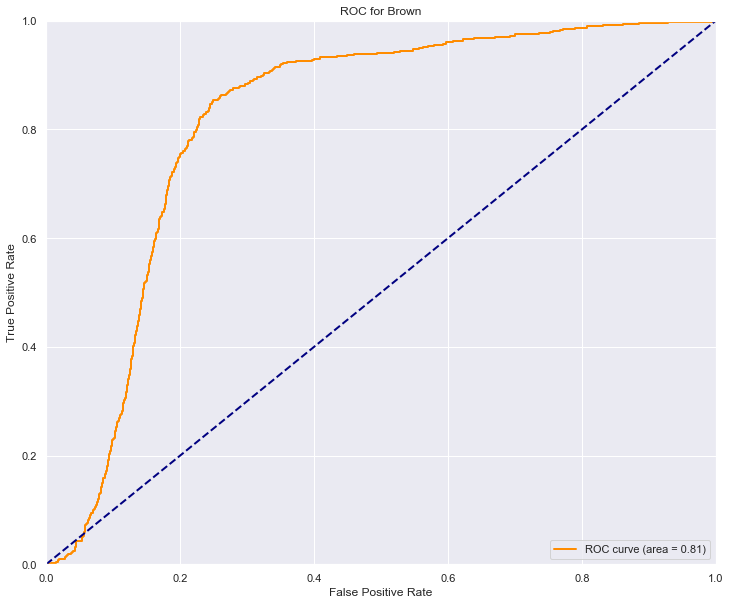

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [20]:
target = 'Brown'
workflow(recipe, features, target)

Number of Porter recipes: 2169
Testing score: 0.9691577102833108


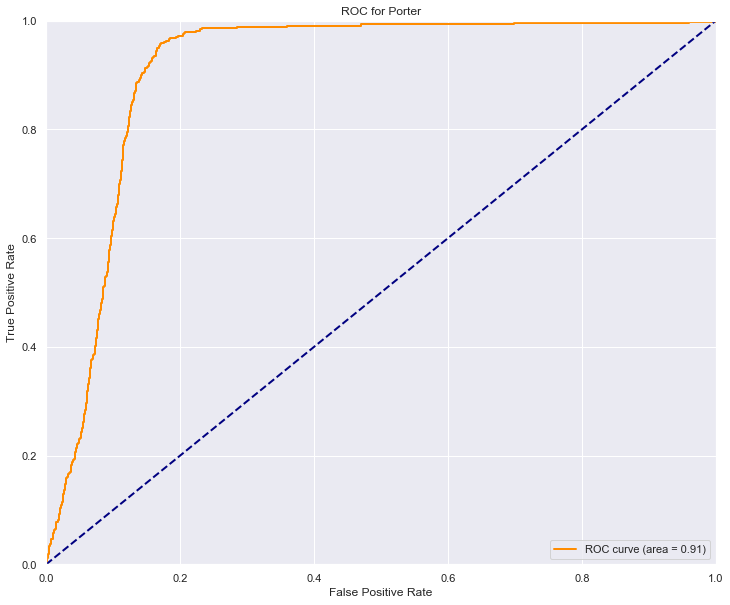

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [21]:
target = 'Porter'
workflow(recipe, features, target)

Number of Amber recipes: 2075
Testing score: 0.9705757226072944


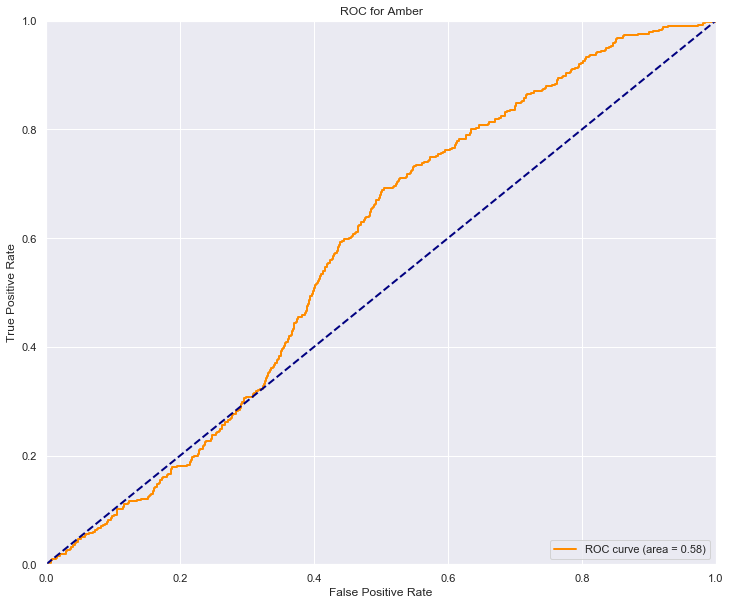

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [22]:
target = 'Amber'
workflow(recipe, features, target)

Number of Blonde recipes: 1693
Testing score: 0.9759642850857675


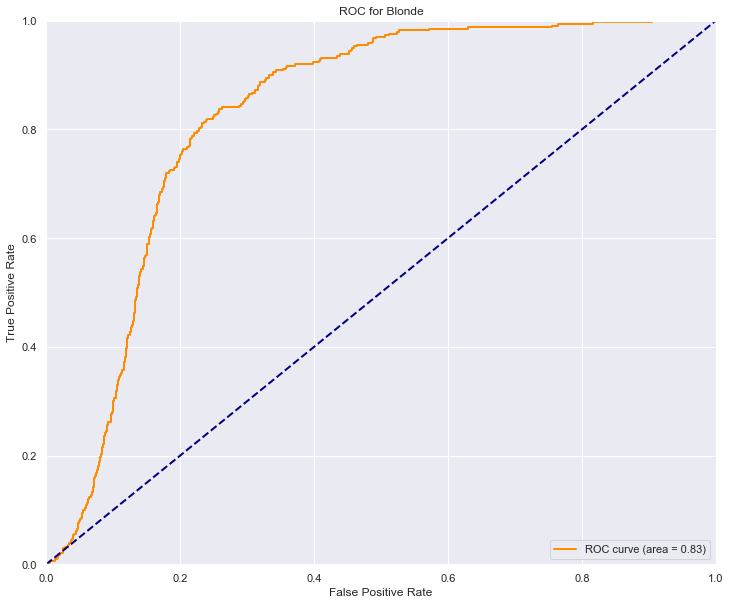

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [23]:

target = 'Blonde'
workflow(recipe, features, target)

Number of Pilsner recipes: 1183
Testing score: 0.9831963146704465


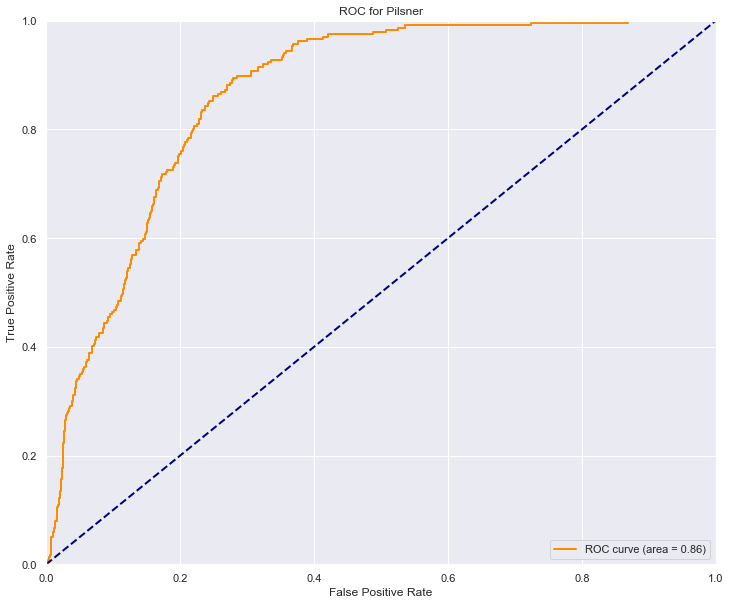

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [24]:
target = 'Pilsner'
workflow(recipe, features, target)

In [25]:
styles = ['IPA','Belgian','Pale Ale', 'Other', 'Stout', 'Lager','German',
          'Specialty','Brown','Porter','Amber','Blonde','Pilsner']

scores = [0.8475606632469684,0.8561399684735307,0.887124247322367,0.9012337711295746,
          0.9474612644276338, 0.9254822581661658, 0.9455473988186078,0.9646909055721471,
          0.9663216353538934,0.9691577102833108, 0.9705757226072944,0.9759642850857675,
          0.9831963146704465]
 
d = {'Styles': styles, 'Scores': scores}
print (len(styles))
print (len(scores))
results = pd.DataFrame(data=d)



13
13


In [26]:
results['Scores'].mean()

0.9338812419352082

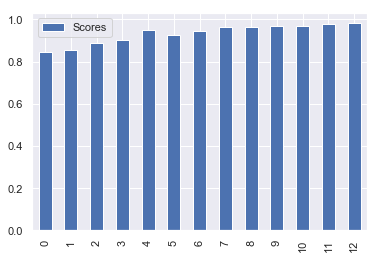

In [27]:
results.plot(kind='bar')